In [1]:
##############################
## IMPORT AND PREPARE DATA ##
############################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
from pyomo.environ import *

# Import data
filename1 = 'HOEP_2015-2019_dataset.csv'
XGboost_2019 = pd.read_csv('HOEP_2019_forecast_XGB1.csv')
XGboost_2018 = pd.read_csv('HOEP_2018_forecast_XGB1.csv')
XGboost_2017 = pd.read_csv('HOEP_2017_forecast_XGB1.csv')
XGboost_2016 = pd.read_csv('HOEP_2016_forecast_XGB1.csv')

dataframe = pd.read_csv(filename1)
cols_of_interest = ["Date","Hour","HOEP"]
dataframe = dataframe[cols_of_interest]

dataframe['HOEP_lag24'] = dataframe.HOEP.shift(24)
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')

# Create different datasets for each year
df_2016 = dataframe.loc[8760:17543].reset_index(drop=True)
df_2016['XGB'] = XGboost_2016.Forecast
df_2017 = dataframe.loc[17544:26303].reset_index(drop=True)
df_2017['XGB'] = XGboost_2017.Forecast
df_2018 = dataframe.loc[26304:35063].reset_index(drop=True)
df_2018['XGB'] = XGboost_2018.Forecast
df_2019 = dataframe.loc[35064:].reset_index(drop=True)
df_2019['XGB'] = XGboost_2019.Forecast
df_2016

,Date,Hour,HOEP,HOEP_lag24,Datetime,XGB
0,2016-01-01,1,-1.09,2.33,2016-01-01 01:00:00,-0.018963
1,2016-01-01,2,-2.41,0.40,2016-01-01 02:00:00,-2.137242
2,2016-01-01,3,-4.23,-3.44,2016-01-01 03:00:00,-2.060675
3,2016-01-01,4,-4.40,-4.30,2016-01-01 04:00:00,-2.327649
4,2016-01-01,5,-4.44,0.00,2016-01-01 05:00:00,-2.174911
...,...,...,...,...,...,...
8779,2016-12-31,20,2.81,11.09,2016-12-31 20:00:00,5.246418
8780,2016-12-31,21,0.00,10.41,2016-12-31 21:00:00,3.072220
8781,2016-12-31,22,0.00,14.37,2016-12-31 22:00:00,1.040984
8782,2016-12-31,23,0.00,16.32,2016-12-31 23:00:00,0.587296


In [3]:
start_time = datetime.now()
### XGB1 EAV CAPTURED ##
##### 2016 ####
###############
df = df_2016.copy()  # choose the year of data we want to optimize for

duration = 12
model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['XGB'] = list(df['XGB'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
XGB1_2016_Y = round(results.real_value.sum()/1000,2)
                       
print("EAV with XGB1 and 8760h planning:", XGB1_2016_Y,"for year 2016")
print("running time:", datetime.now() - start_time)
results

EAV with XGB1 and 8760h planning: 46.74 for year 2016
running time: 0:00:25.952058


,Datetime,HOEP,XGB,Ein,Eout,SOC,value,real_value
0,2016-01-01 01:00:00,-1.09,-0.018963,1.000000,1.221474e-07,6.00,0.018963,1.09
1,2016-01-01 02:00:00,-2.41,-2.137242,1.000000,0.000000e+00,6.86,2.137242,2.41
2,2016-01-01 03:00:00,-4.23,-2.060675,1.000000,0.000000e+00,7.72,2.060675,4.23
3,2016-01-01 04:00:00,-4.40,-2.327649,1.000000,0.000000e+00,8.58,2.327649,4.40
4,2016-01-01 05:00:00,-4.44,-2.174911,1.000000,0.000000e+00,9.44,2.174911,4.44
...,...,...,...,...,...,...,...,...
8779,2016-12-31 20:00:00,2.81,5.246418,0.000000,1.000000e+00,1.00,5.246418,2.81
8780,2016-12-31 21:00:00,0.00,3.072220,0.000000,5.000000e-01,0.50,1.536110,0.00
8781,2016-12-31 22:00:00,0.00,1.040984,0.744186,4.787364e-09,1.14,-0.774686,-0.00
8782,2016-12-31 23:00:00,0.00,0.587296,1.000000,0.000000e+00,2.00,-0.587296,-0.00


In [4]:
start_time = datetime.now()
### HOEP_lag24 EAV CAPTURED ##
##### 2016 ####
###############
df = df_2016.copy()  # choose the year of data we want to optimize for

duration = 12
model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag24']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['HOEP_lag24'] = list(df['HOEP_lag24'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
lag24_2016_Y = round(results.real_value.sum()/1000,2)
                       
print("EAV with HOEP_lag24 and 8760h planning:", lag24_2016_Y,"for year 2016")
print("running time:", datetime.now() - start_time)
results

EAV with HOEP_lag24 and 8760h planning: 29.05 for year 2016
running time: 0:00:28.900091


,Datetime,HOEP,HOEP_lag24,Ein,Eout,SOC,value,real_value
0,2016-01-01 01:00:00,-1.09,2.33,0.0,1.000000e+00,6.000000,2.33,-1.09
1,2016-01-01 02:00:00,-2.41,0.40,1.0,8.578233e-09,6.860000,-0.40,2.41
2,2016-01-01 03:00:00,-4.23,-3.44,1.0,0.000000e+00,7.720000,3.44,4.23
3,2016-01-01 04:00:00,-4.40,-4.30,1.0,0.000000e+00,8.580000,4.30,4.40
4,2016-01-01 05:00:00,-4.44,0.00,1.0,0.000000e+00,9.440000,0.00,4.44
...,...,...,...,...,...,...,...,...
8779,2016-12-31 20:00:00,2.81,11.09,0.0,1.000000e+00,5.475448,11.09,2.81
8780,2016-12-31 21:00:00,0.00,10.41,0.0,1.000000e+00,4.475448,10.41,0.00
8781,2016-12-31 22:00:00,0.00,14.37,0.0,1.000000e+00,3.475448,14.37,0.00
8782,2016-12-31 23:00:00,0.00,16.32,0.0,1.000000e+00,2.475448,16.32,0.00


In [5]:
start_time = datetime.now()

### XGB1 EAV CAPTURED ##
##### 2017 ####
###############
df = df_2017.copy()  # choose the year of data we want to optimize for

duration = 12
model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['XGB'] = list(df['XGB'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
XGB1_2017_Y = round(results.real_value.sum()/1000,2)
                       
print("EAV with XGB1 and 8760h planning:", XGB1_2017_Y,"for year 2017")
print("running time:", datetime.now() - start_time)
results

EAV with XGB1 and 8760h planning: 47.13 for year 2017
running time: 0:00:25.680571


,Datetime,HOEP,XGB,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,0.418567,0.000000e+00,1.000000e+00,6.000000,0.418567,0.000000
1,2017-01-01 02:00:00,0.00,0.418567,9.311186e-09,1.000000e+00,5.000000,0.418567,0.000000
2,2017-01-01 03:00:00,0.00,0.288802,8.695484e-01,4.330084e-08,5.747812,-0.251128,-0.000000
3,2017-01-01 04:00:00,0.00,0.288802,8.668044e-01,4.330084e-08,6.493263,-0.250335,-0.000000
4,2017-01-01 05:00:00,0.00,0.288802,8.648957e-01,4.330084e-08,7.237074,-0.249784,-0.000000
...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,33.989410,0.000000e+00,6.250000e-02,0.062500,2.124338,2.502500
8756,2017-12-31 21:00:00,39.71,35.286961,0.000000e+00,3.125000e-02,0.031250,1.102718,1.240937
8757,2017-12-31 22:00:00,39.37,33.576385,0.000000e+00,1.562499e-02,0.015625,0.524631,0.615156
8758,2017-12-31 23:00:00,39.79,34.567478,0.000000e+00,7.812493e-03,0.007812,0.270059,0.310859


In [6]:
start_time = datetime.now()
### HOEP_lag24 EAV CAPTURED ##
##### 2017 ####
###############
df = df_2017.copy()  # choose the year of data we want to optimize for

duration = 12
model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag24']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['HOEP_lag24'] = list(df['HOEP_lag24'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
lag24_2017_Y = round(results.real_value.sum()/1000,2)
                       
print("EAV with HOEP_lag24 and 8760h planning:", lag24_2017_Y,"for year 2017")
print("running time:", datetime.now() - start_time)
results

EAV with HOEP_lag24 and 8760h planning: 31.34 for year 2017
running time: 0:00:29.267740


,Datetime,HOEP,HOEP_lag24,Ein,Eout,SOC,value,real_value
0,2017-01-01 01:00:00,0.00,13.68,0.0,1.000000,6.000000,13.680000,0.000000
1,2017-01-01 02:00:00,0.00,8.94,0.0,1.000000,5.000000,8.940000,0.000000
2,2017-01-01 03:00:00,0.00,5.41,0.0,1.000000,4.000000,5.410000,0.000000
3,2017-01-01 04:00:00,0.00,0.00,1.0,0.000000,4.860000,0.000000,-0.000000
4,2017-01-01 05:00:00,0.00,0.00,1.0,0.000000,5.720000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...
8755,2017-12-31 20:00:00,40.04,39.51,0.0,0.305000,0.305000,12.050550,12.212200
8756,2017-12-31 21:00:00,39.71,41.11,0.0,0.152500,0.152500,6.269275,6.055775
8757,2017-12-31 22:00:00,39.37,43.27,0.0,0.076250,0.076250,3.299338,3.001962
8758,2017-12-31 23:00:00,39.79,39.20,0.0,0.038125,0.038125,1.494500,1.516993


In [7]:
start_time = datetime.now()
### XGB1 EAV CAPTURED ##
##### 2018 ####
###############
df = df_2018.copy()  # choose the year of data we want to optimize for

duration = 12
model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['XGB'] = list(df['XGB'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
XGB1_2018_Y = round(results.real_value.sum()/1000,2)

print("EAV with XGB1 and 8760h planning:", XGB1_2018_Y, "for year 2018")
print("running time:", datetime.now() - start_time)

EAV with XGB1 and 8760h planning: 51.32 for year 2018
running time: 0:00:24.517513


In [8]:
start_time = datetime.now()
### HOEP_lag24 EAV CAPTURED ##
##### 2018 ####
###############
df = df_2018.copy()  # choose the year of data we want to optimize for
duration = 12

model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag24']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
#solver = SolverFactory('glpk')
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['HOEP_lag24'] = list(df['HOEP_lag24'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
lag24_2018_Y = round(results.real_value.sum()/1000,2)
                       
print("EAV with HOEP_lag24 and 8760h planning:", lag24_2018_Y,"for year 2018")
print("running time:", datetime.now() - start_time)
results

EAV with HOEP_lag24 and 8760h planning: 26.93 for year 2018
running time: 0:00:26.687710


,Datetime,HOEP,HOEP_lag24,Ein,Eout,SOC,value,real_value
0,2018-01-01 01:00:00,51.29,40.57,0.0,1.000000e+00,6.00,4.057000e+01,5.129000e+01
1,2018-01-01 02:00:00,43.59,50.90,0.0,1.000000e+00,5.00,5.090000e+01,4.359000e+01
2,2018-01-01 03:00:00,93.60,46.36,0.0,1.000000e+00,4.00,4.636000e+01,9.360000e+01
3,2018-01-01 04:00:00,54.78,34.85,1.0,0.000000e+00,4.86,-3.485000e+01,-5.478000e+01
4,2018-01-01 05:00:00,14.35,41.80,0.0,0.000000e+00,4.86,-1.832612e-08,0.000000e+00
...,...,...,...,...,...,...,...,...
8755,2018-12-31 20:00:00,5.62,5.89,1.0,0.000000e+00,3.80,-5.890000e+00,-5.620000e+00
8756,2018-12-31 21:00:00,8.95,9.69,0.0,2.132379e-08,3.80,2.846720e-07,1.908480e-07
8757,2018-12-31 22:00:00,5.81,13.36,0.0,1.000000e+00,2.80,1.336000e+01,5.810000e+00
8758,2018-12-31 23:00:00,2.87,21.98,0.0,1.000000e+00,1.80,2.198000e+01,2.870000e+00


In [9]:
start_time = datetime.now()
### XGB1 EAV CAPTURED ##
##### 2019 ####
###############

df = df_2019.copy()  # choose the year of data we want to optimize for

duration = 12

model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['XGB'] = list(df['XGB'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
XGB1_2019_Y = round(results.real_value.sum()/1000,2)

print("EAV with XGB1 and 8760h planning:", XGB1_2019_Y,"for year 2019")
print("running time:", datetime.now() - start_time)

EAV with XGB1 and 8760h planning: 32.88 for year 2019
running time: 0:00:24.475567


In [10]:
start_time = datetime.now()
### HOEP_lag24 EAV CAPTURED ##
##### 2019 ####
###############
df = df_2019.copy()  # choose the year of data we want to optimize for

duration = 12

model = ConcreteModel()
    
# Variables of the model
model.T = Set(initialize=df.index, ordered=True)
model.Rmax = Param(initialize=1, within=Any) 
model.Smax = Param(initialize=duration, within=Any)
model.Dmax = Param(initialize=duration, within=Any)
model.eta = Param(initialize=0.86)

model.Ein = Var(model.T, domain=NonNegativeReals)  
model.Eout = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals) 
model.value = Var(model.T)
        
# Constraints
def storage_state(model, t):
    if df['Datetime'].iloc[0] == df.Datetime[0]:  
        if t == model.T.first():
            return model.Z[t] == duration/2 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    else:
        if t == model.T.first():
            return model.Z[t] == last_period_end_SOC + model.Ein[t]*model.eta - model.Eout[t] 
        else:
            return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
model.charge_state = Constraint(model.T, rule=storage_state)

def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

def positive_charge(model, t): 
    return model.Eout[t] <= model.Z[t] 
model.positive_charge = Constraint(model.T, rule=positive_charge)

def max_SOC(model, t): 
    return model.Z[t] <= model.Smax
model.max_SOC = Constraint(model.T, rule=max_SOC)
        
def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag24']                
model.value_constraint = Constraint(model.T, rule=value_constraint)

# Objective function and optimization
profits = sum(model.value[t] for t in model.T)
model.objective = Objective(expr=profits, sense=maximize)

# Solve model
solver = SolverFactory('ipopt')
solver.solve(model) 
        
SOC = list(model.Z.get_values().values())
last_period_end_SOC = SOC[-1]
        
Profits = model.objective()

# Extract model output in list and Present final results in a dataframe
results = pd.DataFrame(list(df['Datetime']), columns=['Datetime'])
results['HOEP'] = list(df['HOEP'])
results['HOEP_lag24'] = list(df['HOEP_lag24'])
results['Ein'] = list(model.Ein.get_values().values())
results['Eout'] = list(model.Eout.get_values().values())
results['SOC'] = SOC
results['value'] = list(model.value.get_values().values())
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
lag24_2019_Y = round(results.real_value.sum()/1000,2)
                       
print("EAV with HOEP_lag24 and 8760h planning:", lag24_2019_Y)
print("running time:", datetime.now() - start_time)
results

EAV with HOEP_lag24 and 8760h planning: 16.6
running time: 0:00:29.073433


,Datetime,HOEP,HOEP_lag24,Ein,Eout,SOC,value,real_value
0,2019-01-01 01:00:00,0.00,20.44,0.000000,1.000000e+00,6.000000,20.440000,0.000000
1,2019-01-01 02:00:00,0.00,13.33,0.000000,1.000000e+00,5.000000,13.330000,0.000000
2,2019-01-01 03:00:00,-0.11,13.35,0.000000,1.000000e+00,4.000000,13.350000,-0.110000
3,2019-01-01 04:00:00,-1.84,28.51,0.000000,1.000000e+00,3.000000,28.510001,-1.840000
4,2019-01-01 05:00:00,-0.47,26.66,0.000000,1.000000e+00,2.000000,26.660001,-0.470000
...,...,...,...,...,...,...,...,...
8755,2019-12-31 20:00:00,0.00,0.00,0.602809,3.619311e-01,5.434179,0.000000,-0.000000
8756,2019-12-31 21:00:00,0.00,0.00,0.580596,3.858462e-01,5.547645,0.000000,-0.000000
8757,2019-12-31 22:00:00,-0.05,0.00,0.558396,4.101539e-01,5.617712,0.000000,0.007412
8758,2019-12-31 23:00:00,-0.04,0.00,0.536081,4.349498e-01,5.643791,0.000000,0.004045


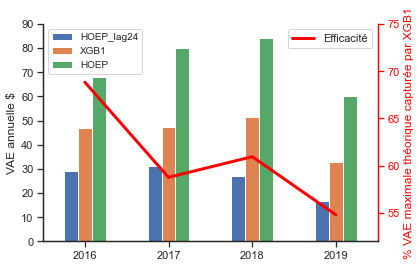

In [12]:
## Create dataframe with PERFECT FORESIGHT, BACKCASTING AND XGB1 value of storage to compare.
import numpy as np
import pandas as pd
%matplotlib inline  
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt 
sns.set() # Use seaborn style

years = ['2016', '2017', '2018', '2019']
XGB1 = [XGB1_2016_Y, XGB1_2017_Y, XGB1_2018_Y, XGB1_2019_Y]
HOEP_lag24 = [lag24_2016_Y, lag24_2017_Y, lag24_2018_Y, lag24_2019_Y]
HOEP = [67.9, 80.2, 84.2, 60.0] # 2016,2017,2018,2019
dictionary = {'Année':years, 'HOEP_lag24':HOEP_lag24, 'XGB1':XGB1, 'HOEP':HOEP}
imp_df = pd.DataFrame(dictionary)
imp_df['Efficacité'] = imp_df.XGB1/imp_df.HOEP * 100

with sns.axes_style("ticks", {"grid.color": "white"}):
    fig, ax = plt.subplots()
    imp_df[['HOEP_lag24', 'XGB1', 'HOEP']].plot(kind='bar', ax=ax)
    plt.legend(loc = 'upper left', fontsize = 'small')
    plt.ylabel('VAE annuelle $')
    ax.set_ylim(0, 90)
    plt.xticks(rotation = 360) 
    ax2 = ax.twinx()
    sns.lineplot(data=imp_df,x=imp_df['Année'], y='Efficacité', markers='o', linewidth=3.0,
                 color="red",legend='full',label='Efficacité',ax=ax2)
    ax2.legend(loc='upper right')
    ax2.tick_params(axis='y', colors='red')
    ax2.spines["right"].set_color("red")
    ax2.set_ylim(52, 75)
    sns.despine(top=True, right=False)
    plt.ylabel("% VAE maximale théorique capturée par XGB1", color='red')
    plt.savefig('XGB1_eff',dpi=1100, bbox_inches='tight')